# Facenet

In [ ]:
import torch
import torch.nn as nn
import os
import torch
import itertools
import time
import torchvision
import numpy as np
from PIL import Image
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import transforms
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
from torch.autograd import Function
import math

## Data loader

In [ ]:
class DataLoader():
    def __init__(self, dir_path, transform):
        self.images_dict = {}
        self.id2image = {}
        self.labels = None
        self.dir_path = dir_path
        self.transform = transform
        self.load_images()

    def load_images(self):
        # returns labels/names list
        self.labels = os.listdir(self.dir_path)
        for label in self.labels:
            path = os.path.join(self.dir_path, label)
            if 'DS_Store' in path:
                continue
            images = os.listdir(path)
            self.images_dict[label] = images
            for image_id in images:
                img_path = os.path.join(path, image_id)
                self.id2image[image_id] = self.transform(Image.open(img_path))

    def gen_data(self):
        labels = []
        image_ids = []
        for label, images in self.images_dict.items():
            num_images = len(images)
            labels.extend([label] * num_images)
            image_ids.extend(images)
        return image_ids, labels

    def get_image(self, image_id):
        return self.id2image[image_id]

## Model

In [ ]:
class Resnet152(nn.Module):
    def __init__(self, embedding_dim = 512, pretrained = False):
        super(Resnet152, self).__init__()
        self.embedding_dim = embedding_dim
        self.resnet152 = models.resnet152(pretrained=pretrained)
        self.linear = nn.Linear(self.resnet152.fc.in_features, embedding_dim)
        self.resnet152.fc = self.linear
        # self.batch_norm = nn.BatchNorm1d(embedding_dim, momentum=0.01)
        self.init_weights()
    
    def init_weights(self):
        self.linear.weight.data.normal_(0.0, 0.02)
        self.linear.bias.data.fill_(0)
    
    def forward(self, images):
        embed = self.resnet152(images)
        # embed = self.batch_norm(embed)
        return embed

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class TripletNet(nn.Module):
    def __init__(self, cnn):
        super(TripletNet, self).__init__()
        self.embedding = cnn

    # def forward(self, images_tensor, minibatch_X):
    def forward(self, images_tensor):
        embeds = self.embedding(images_tensor)
        # id2embeds = {}
        # minibatch_size = len(minibatch_X)
        # for i in range(minibatch_size):
        #    x = minibatch_X[i]
        #    id2embeds[x] = embeds[i, :]
        # return id2embeds
        return embeds

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, alpha = 0.2):
        super(TripletLoss, self).__init__()
        self.alpha = alpha

    def forward(self, anchor, positive, negative):
        alpha = self.alpha
        pos_dist = anchor - positive
        pos_dist = torch.pow(pos_dist, 2).sum(dim=1)
        neg_dist = anchor - negative
        neg_dist = torch.pow(neg_dist, 2).sum(dim=1)
        basic_loss = pos_dist - neg_dist + alpha
        # loss = torch.clamp(basic_loss, min=0.0).sum()
        relu = nn.ReLU()
        loss = relu(basic_loss)
        return loss.mean()

def triplet_loss(anchor, positive, negative, alpha=0.2):
    return TripletLoss(alpha)(anchor, positive, negative)

## Tools

In [ ]:

def shuffle_data(data, seed = 0):
    image_ids, labels = data
    shuffled_image_ids = []
    shuffled_labels = []
    num_images = len(image_ids)
    torch.manual_seed(seed)
    perm = list(torch.randperm(num_images))
    for i in range(num_images):
        shuffled_image_ids.append(image_ids[perm[i]])
        shuffled_labels.append(labels[perm[i]])
    return shuffled_image_ids, shuffled_labels

def make_minibatches(data, minibatch_size = 16,  seed = 0, shuffle = 'random'):
    X, Y = data
    m = len(X)
    minibatches = []
    if shuffle == 'sequential':
        shuffled_X, shuffled_Y = X, Y

    elif shuffle == 'random':
        shuffled_X, shuffled_Y = shuffle_data(data, seed = seed)

    num_complete_minibatches = math.floor(m/minibatch_size)
    for k in range(0, num_complete_minibatches):
        minibatch_X = shuffled_X[k * minibatch_size : k * minibatch_size + minibatch_size]
        minibatch_Y = shuffled_Y[k * minibatch_size : k * minibatch_size + minibatch_size]
        minibatches.append((minibatch_X, minibatch_Y))

    rem_size = m - num_complete_minibatches * minibatch_size
    if m % minibatch_size != 0:
        minibatch_X = shuffled_X[num_complete_minibatches * minibatch_size : m]
        minibatch_Y = shuffled_Y[num_complete_minibatches * minibatch_size : m]
        minibatches.append((minibatch_X, minibatch_Y))

    return minibatches

def batch2images_tensor(minibatch_X, dataloader, gpu_device):
    minibatch_size = len(minibatch_X)
    images_tensor = torch.zeros(minibatch_size, 3, 224, 224)
    for i in range(minibatch_size):
        x = minibatch_X[i]
        x_image = dataloader.get_image(x)
        images_tensor[i, :, :, :] = x_image
    images_tensor = Variable(images_tensor)
    if torch.cuda.is_available():
        with torch.cuda.device(gpu_device):
            images_tensor = images_tensor.cuda()
    return images_tensor

def gen_triplets(minibatch, id2embeds, embedding_dim, device, mode = 'all'):
    X, Y = minibatch
    Y_prod = itertools.product(Y, repeat=3)
    X_prod = itertools.product(X, repeat=3)
    triplet = []
    #print(minibatch)
    for x, y  in zip(X_prod, Y_prod):
        
        xa, xp, xn = x
        ya, yp, yn = y
        if (ya == yp) and (ya!=yn) and (xa!=xp):
            triplet.append((xa, xp, xn))
    #print(triplet)
    num_triplets = len(triplet)
    anchor = torch.zeros(num_triplets, embedding_dim)
    positive = torch.zeros(num_triplets, embedding_dim)
    negative = torch.zeros(num_triplets, embedding_dim)
#     if torch.cuda.is_available():
#         with torch.cuda.device(device):
#             anchor = anchor.cuda()
#             positive = positive.cuda()
#             negative = negative.cuda()

    for i in range(num_triplets):
        xa, xp, xn = triplet[i]
        anchor[i, :] = id2embeds[xa]
        positive[i, :] = id2embeds[xp]
        negative[i, :] = id2embeds[xn]
            
    return anchor, positive, negative

def label2embeds_list2dict(labels_list, embeds):
    label2embeds = {}
    num_labels = len(labels_list)
    for i in range(num_labels):
        label = labels_list[i]
        label2embeds[label] = embeds[i, :]
    return label2embeds

def final_label2embeds(triplet_net, train_dataloader, gpu_device):
    labels_list = []
    image_ids = []
    for label, images_list in train_dataloader.images_dict.items():
        image_ids.append(images_list[0])
        labels_list.append(label)

    images_tensor = batch2images_tensor(image_ids, train_dataloader, gpu_device)
    with torch.no_grad():
        embeds = triplet_net.embedding(images_tensor)
    label2embeds = label2embeds_list2dict(labels_list, embeds)
    return label2embeds

def who_is_it(label2embeds, embed):
    labels = []
    num_labels = len(label2embeds)
    embedding_dim = embed.shape[0]
    embeds = torch.zeros(num_labels, embedding_dim)
    i = 0
    for label, cur_embed in label2embeds.items():
        labels.append(label)
        embeds[i, :] = cur_embed
        i += 1
    dist = torch.pow(embeds - embed, 2).sum(dim = 1)
    index = torch.argmin(dist).tolist()
    return labels[index]

def accuracy(data, dataloader, label2embeds, triplet_net, gpu_device):
    image_ids, Y = data
    num_data = len(Y)
    embedding_dim = triplet_net.embedding.embedding_dim
    embeds = torch.zeros(num_data, embedding_dim)
    minibatch_size = 32
    minibatches = make_minibatches(data, minibatch_size = minibatch_size,  seed = 0, shuffle = 'sequential')
    start = 0
    end = 0
    for cur_minibatch in minibatches:
        minibatch_X, _ = cur_minibatch
        cur_minibatch_size = len(minibatch_X)
        end += cur_minibatch_size
        images_tensor = batch2images_tensor(minibatch_X, dataloader, gpu_device)
        with torch.no_grad():
            embeds[start:end, :] = triplet_net(images_tensor)
        start = end

    acc = 0
    # pred = []

    for i in range(num_data):
        embed = embeds[i]
        target_label = Y[i]
        predicted_label = who_is_it(label2embeds, embed)
        if predicted_label == target_label:
            acc += 1
            # pred.append(predicted_label)
    return acc, num_data

## Train and test


In [ ]:
if __name__ == '__main__':

    train_dir = '../input/lfwvincie/lfw_modified/train'
    dev_dir = '../input/lfwvincie/lfw_modified/dev'

    transform = transforms.Compose([transforms.Resize((224, 224)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5),
                                                        (0.5, 0.5, 0.5))
                                    ])
    train_accs=[]
    dev_accs=[]
    train_losses=[]

    tic = time.time()
    train_dataloader = DataLoader(train_dir, transform)
    train_data = train_dataloader.gen_data()
    toc = time.time()
    print('train_data loaded %.2f' %((toc-tic)/60))

    tic = time.time()
    dev_dataloader = DataLoader(dev_dir, transform)
    dev_data = dev_dataloader.gen_data()
    toc = time.time()
    print('dev_data loaded %.2f' %((toc-tic)/60))

    embedding_dim = 64#128
    # model_name = 'alexnet'
    # model_name = 'resnet'
    model_name = 'resnet152'
    if not os.path.exists(model_name):
        os.makedirs(model_name)

    if model_name == 'alexnet':
        cnn = Alexnet(embedding_dim = embedding_dim, pretrained = False)
    elif model_name == 'resnet':
        cnn = Resnet(embedding_dim = embedding_dim, pretrained = False)
    elif model_name == 'resnet152':
        cnn = Resnet152(embedding_dim = embedding_dim, pretrained = False)
    triplet_net = TripletNet(cnn)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    triplet_net.to(device)

#     gpu_device = 1
#     if torch.cuda.is_available():
#         with torch.cuda.device(gpu_device):
#             triplet_net.cuda()

    num_epochs = 1500
    minibatch_size = 8
    learning_rate = 1e-4
    params = triplet_net.parameters()
    optimizer = torch.optim.Adam(params, lr = learning_rate)

    for epoch in range(num_epochs):
        triplet_net.train()
        minibatches = make_minibatches(train_data, minibatch_size = minibatch_size, seed = epoch)
        loss = []
        tic = time.time()
        for cur_minibatch in minibatches:
            #print(cur_minibatch)
            triplet_net.zero_grad()
#             id2embeds = batch2embeddings(cur_minibatch[0], triplet_net, train_dataloader, device)
#             anchor, positive, negative = gen_triplets(cur_minibatch, id2embeds, embedding_dim,device)
            
            images_tensor = batch2images_tensor(cur_minibatch[0], train_dataloader, device)
            embeds = triplet_net(images_tensor)
            id2embeds = label2embeds_list2dict(cur_minibatch[0], embeds)
            #print(id2embeds)
            anchor, positive, negative = gen_triplets(cur_minibatch, id2embeds, embedding_dim, device)
            #print(anchor.shape)
            if anchor.shape[0] != 0:
                l = triplet_loss(anchor, positive, negative)
                #print(l)
                loss.append(l)
                l.backward()
                optimizer.step()
        toc = time.time()

        print('epoch %d train_loss %f time %.2f mins' 
                %(epoch, torch.mean(torch.Tensor(loss)), (toc-tic)/60))
        label2embeds = final_label2embeds(triplet_net, train_dataloader, device)
        
#         if (epoch + 1) % 100 == 0:
#             torch.save(label2embeds, os.path.join(model_name, 'iter_%d_label2embeds.pkl'%(epoch)))
#             torch.save(triplet_net.state_dict(), os.path.join(model_name, 'iter_%d_triplet_net.pkl'%(epoch)))

        if (epoch+1) % 10 == 0:
            train_acc, num_train = accuracy(train_data, train_dataloader, label2embeds, triplet_net, device)
            dev_acc, num_dev = accuracy(dev_data, dev_dataloader, label2embeds, triplet_net, device)
            print('%d %f %f %f' 
            %(epoch, torch.mean(torch.Tensor(loss)), train_acc/num_train, dev_acc/num_dev))
            train_losses.append(torch.mean(torch.Tensor(loss)))
                
            #train accuracy
            tic = time.time()
            train_acc, num_train = accuracy(train_data, train_dataloader, label2embeds, triplet_net, device)
            toc = time.time()
            print('train_acc %f correct %d/%d time %.2f mins' 
                %(train_acc/num_train, train_acc, num_train, (toc-tic)/60))
            train_accs.append(train_acc/num_train)

            # dev accuracy
            tic = time.time()
            dev_acc, num_dev = accuracy(dev_data, dev_dataloader, label2embeds, triplet_net, device)
            toc = time.time()
            print('dev_acc %f correct %d/%d time %.2f mins' 
                    %(dev_acc/num_dev, dev_acc, num_dev, (toc-tic)/60))
            dev_accs.append(dev_acc/num_dev)

In [ ]:
torch.save(label2embeds, os.path.join(model_name, 'iter_%d_label2embeds.pkl'%(epoch)))
torch.save(triplet_net.state_dict(), os.path.join(model_name, 'iter_%d_triplet_net.pkl'%(epoch)))

In [ ]:
x=np.arange(len(train_losses))
y=train_losses
plt.plot(x,y)
plt.title('loss x is for every 10 epoch')

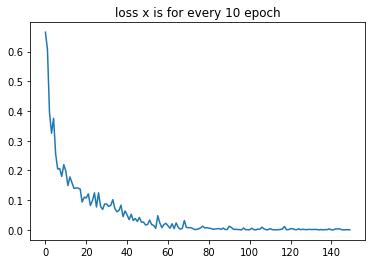

In [ ]:
x=np.arange(len(train_accs))
y=train_accs
z=dev_accs
plt.plot(x,y,label='train')
plt.plot(x,z,label='validate')
plt.legend()
plt.title('Accuracy x is every 10 epoch')

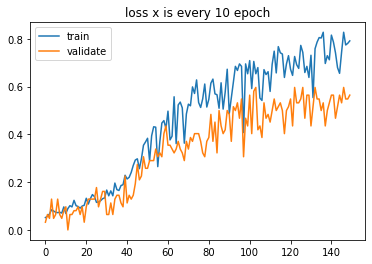